Получаем данные по акциям Apple с помощью YahooFinance Dataset:

In [74]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2009, 1, 1)
end = datetime.datetime.now()

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-06-12,195.970001,193.389999,193.949997,194.190002,18253200.0,194.190002
2019-06-13,196.789993,193.600006,194.699997,194.149994,21674600.0,194.149994
2019-06-14,193.589996,190.300003,191.550003,192.740005,18761500.0,192.740005
2019-06-17,194.960007,192.169998,192.899994,193.889999,14651700.0,193.889999
2019-06-18,200.289993,195.229996,196.050003,198.449997,24023777.0,198.449997


Рассчитываем скользящее среднее для последних 100 дней цены закрытия акций (показываем последние 10)

In [75]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail(10)

Date
2019-06-05    181.793744
2019-06-06    182.135365
2019-06-07    182.549001
2019-06-10    182.956485
2019-06-11    183.367720
2019-06-12    183.763629
2019-06-13    184.149616
2019-06-14    184.556419
2019-06-17    184.968571
2019-06-18    185.438425
Name: Adj Close, dtype: float64

рисуем график

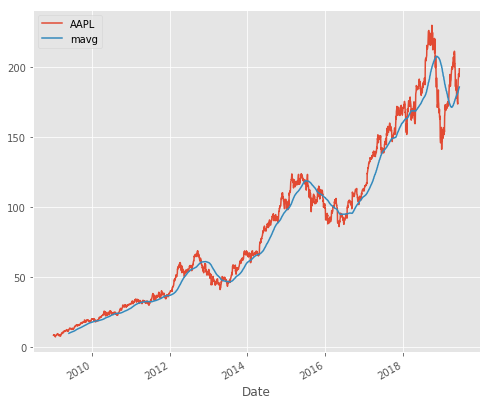

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# регулируем размер matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# и стиль matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

Надо определить риск и доходность.

"Ожидаемая доходность портфеля рассчитывается путем умножения веса каждого актива на его ожидаемую доходность и сложения значений для каждой инвестиции".
Выглядит так: 
$$ $$
$$r_t = \frac{p_t - p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1$$

In [77]:
rets = close_px / close_px.shift(1) - 1
rets.head()

Date
2009-01-02         NaN
2009-01-05    0.042204
2009-01-06   -0.016494
2009-01-07   -0.021608
2009-01-08    0.018569
Name: Adj Close, dtype: float64

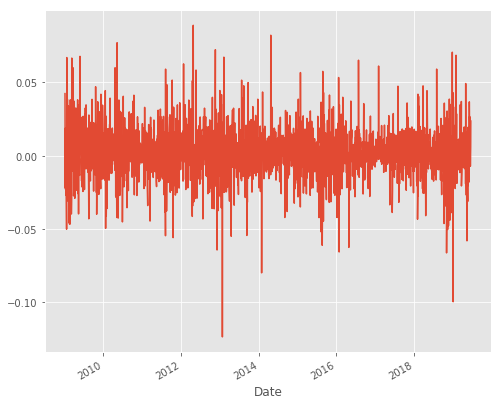

In [78]:
rets.plot(label='return')

Смотрим на корреляцию Apple с  GE, Google, IBM и Microsoft).

In [79]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',
                               start=start, 
                               end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2019-06-12,194.190002,10.28,1077.030029,134.869995,131.490005
2019-06-13,194.149994,10.31,1088.770020,135.759995,132.320007
2019-06-14,192.740005,10.23,1085.349976,135.149994,132.449997
2019-06-17,193.889999,10.05,1092.500000,134.949997,132.850006
2019-06-18,198.449997,10.42,1103.599976,136.389999,135.160004


In [80]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.346624,0.493309,0.408626,0.445941
GE,0.346624,1.000000,0.365656,0.426866,0.358924
GOOG,0.493309,0.365656,1.000000,0.434274,0.531145
IBM,0.408626,0.426866,0.434274,1.000000,0.486234
MSFT,0.445941,0.358924,0.531145,0.486234,1.000000


Text(0,0.5,'Returns GE')

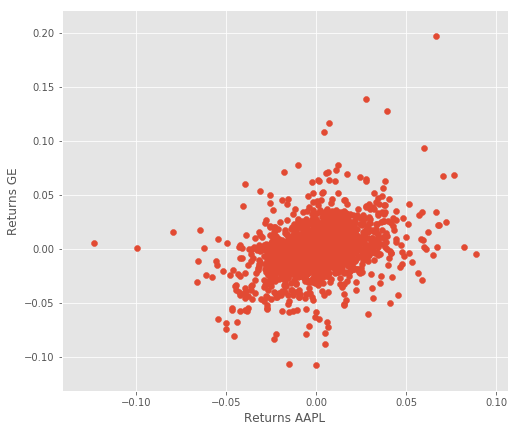

In [81]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

Делаем матрицу разброса со всеми данными конкурентов 

Слева: доходы, скорее всего, будут отрицательными в долгосрочной перспективе

центр: доходы, скорее всего, будут 0 в долгосрочной перспективе

справа: доходы, скорее всего, будут положительными в долгосрочной перспективе

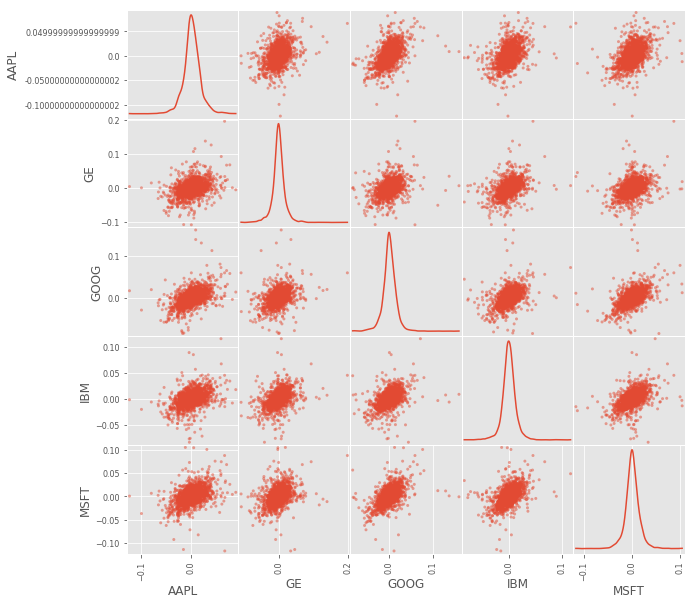

In [82]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

Чтобы показать положительные корреляции, будем использовать тепловые карты для визуализации диапазонов корреляции между конкурирующими акциями (чем светлее цвет, тем больше корреляции между двумя акциями).

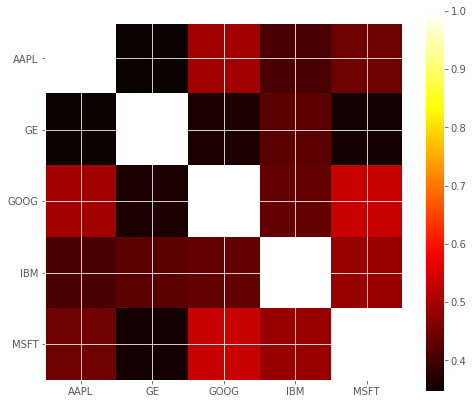

In [83]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

Помимо корреляции анализируем риски и доходность каждой акции - извлекаем среднее значение доходности (Return Rate) и стандартное отклонение доходности (Risk).

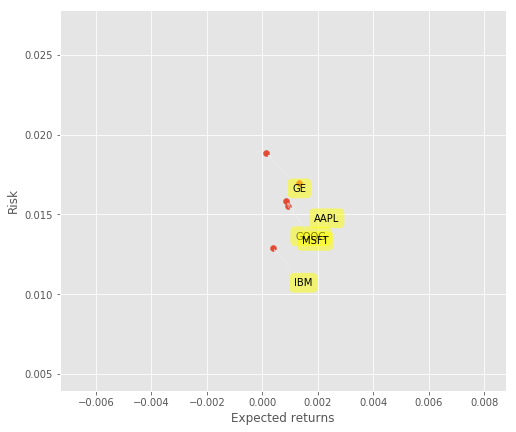

In [84]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (40, -40),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

(выше 0,15 - ок для продажи, ниже - для покупки)

In [85]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,13.005714,12.165714,12.268572,12.964286,186503800.0,8.611461
2009-01-05,13.740000,13.244286,13.310000,13.511429,295402100.0,8.974896
2009-01-06,13.881429,13.198571,13.707143,13.288571,322327600.0,8.826868
2009-01-07,13.214286,12.894286,13.115714,13.001429,188262200.0,8.636136
2009-01-08,13.307143,12.862857,12.918571,13.242857,168375200.0,8.796504


In [86]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2009-01-02,8.611461,186503800.0,6.479340,5.670701
2009-01-05,8.974896,295402100.0,3.668851,1.513361
2009-01-06,8.826868,322327600.0,5.138683,-3.053674
2009-01-07,8.636136,188262200.0,2.461266,-0.871363
2009-01-08,8.796504,168375200.0,3.354913,2.510227


In [87]:
import math
import numpy as np
from sklearn import preprocessing, model_selection, svm


# Сбросить пропущенное значение
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# хотим отделить 1 процент данных для прогноза
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# хотим предсказать AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Масштабируем X, чтобы у всех было одинаковое распределение для линейной регрессии.
X = preprocessing.scale(X)

# ищем серии данных старого X и нового X для генерации и оценки модели
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(2632, 4)
Dimension of X (2605, 4)
Dimension of y (2605,)


In [88]:
# Разделение обучения и тестирования модели с помощью перекрестного теста
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

строим модель

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
    
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

Тестим

In [90]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

print("The linear regression confidence is ",confidencereg)
print("The quadratic regression 2 confidence is ",confidencepoly2)
print("The quadratic regression 3 confidence is ",confidencepoly3)
print("The knn regression confidence is ",confidenceknn)

The linear regression confidence is  0.9739287311565794
The quadratic regression 2 confidence is  0.9747380747444249
The quadratic regression 3 confidence is  0.9752174075588316
The knn regression confidence is  0.9562102904047498


Показатель точности хороший (>0,95) для большинства тестов.
Однако, есть еще много параметров для рассмотрения :)